<div style="background-color: darkred; padding: 10px; color: white;">

# Soma Proposal Generation 

</div>

<div style="background-color: darkblue; padding: 10px; color: white;">

## Section 1: Proposal Generation in a Single Image Patch

<div style="font-size: 18px;">
    We provide an overview of the main routines used to generate soma proposals within a single image patch. The proposal generation process follows the algorithm outlined below:
    <br><br>

<pre style="background-color: darkblue; color: white; font-family: monospace;">
    Soma Proposal Generation Algorithm
        1. Detect Initial Proposals - detect_blobs()
            a. Smooth image with Gaussian filter to reduce false positives.
            b. Laplacian of Gaussian (LoG) to enhance regions where the
               intensity changes dramatically (i.e. higher gradient), then
               apply a non-linear maximum filter.
            c. Generate initial set of proposals by detecting local maximas
               that lie outside of the image margins.
            d. Shift each proposal to the brightest voxel in its neighborhood.
               If the brightness is below a threshold, reject the proposal.

        2. Filter Initial Proposals - filter_proposals()
            a. Compute distances between proposals and merges proposals within
               a given distance threshold.
            b. If the number of proposals exceeds a certain threshold, the top
               k brightest proposals are kept.
            c. Fit Gaussian to neighborhood centered at proposal and compute
               fitness score by comparing fitted Gaussian and image values.
               Proposals are discarded if (1) fitness is below threshold or
               (2) standard deviation of Gaussian is out of range.
               
</pre>
</div>
</div>

### Imports


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings

from random import sample
from skimage.feature import peak_local_max
from scipy.ndimage import gaussian_filter, gaussian_laplace, maximum_filter
from scipy.optimize import curve_fit, OptimizeWarning
from time import time

from aind_exaspim_soma_detection import soma_proposal_generation as spg
from aind_exaspim_soma_detection.utils import img_util, util

warnings.filterwarnings("ignore", category=OptimizeWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
%matplotlib inline


### Subroutines

In [2]:
def detect_blobs(img_patch, bright_threshold, LoG_sigma, margin):
    # Preprocess image
    LoG = gaussian_laplace(img_patch, LoG_sigma)

    # Detect local maximas
    peaks = list()
    for peak in peak_local_max(maximum_filter(LoG, 5), min_distance=5):
        peak = tuple([int(x) for x in peak])
        is_inbounds = spg.is_inbounds(img_patch.shape, peak, margin)
        if LoG[peak] > 0 and is_inbounds:
            peaks.append(peak)
    return spg.shift_to_brightest(img_patch, peaks, bright_threshold), LoG


def gaussian_fitness_filtering(img_patch, proposals, r=4):
    # Main
    accepts = list()
    rejects = list()
    for proposal in proposals:
        # Extract neighborhood
        x0, y0, z0 = tuple(map(int, proposal))
        x_min, x_max = max(0, x0 - r), min(img_patch.shape[0], x0 + r + 1)
        y_min, y_max = max(0, y0 - r), min(img_patch.shape[1], y0 + r + 1)
        z_min, z_max = max(0, z0 - r), min(img_patch.shape[2], z0 + r + 1)
        nbhd = img_patch[x_min:x_max, y_min:y_max, z_min:z_max]

        # Fit Gaussian
        fit, params = spg.gaussian_fitness(nbhd)
        mean, std = params[0:3], abs(params[3:6])

        # Check whether to filter
        proposal = tuple(map(int, proposal))
        feasible_range = all(std > 0.4) and all(std < 10)
        if fit > 0.75 and (feasible_range and np.mean(std) > 0.75):
            print("Accept:", img_patch[proposal], fit, std, np.mean(std))
            proposal = [proposal[i] + mean[i] - r for i in range(3)]
            accepts.append(proposal)
        else:
            print("Reject:", img_patch[proposal], fit, std, np.mean(std))
            rejects.append(proposal)
    return accepts, rejects


### Initializations

In [3]:
# Parameters
bucket_name = "aind-open-data"
brain_id = "719654"
multiscale = 4

bright_threshold = 170
d = 16  # image margin

# Open img
prefix_lookup = util.read_json("/root/capsule/data/exaspim_image_prefixes.json")
img = img_util.open_img(prefix_lookup[brain_id] + str(multiscale))
print("Image Shape:", img.shape)


Image Shape: (1, 1, 1799, 1796, 3893)


### Main

Reject: 359 0.6119913686012664 [1.71084195 0.79724241 1.10867517] 1.20558650779135
Reject: 302 0.6009024634975639 [0.82336421 0.8690589  1.1508867 ] 0.9477699368322172

# Proposals: 0
# Rejects: 2
Runtime: 0.3113076686859131


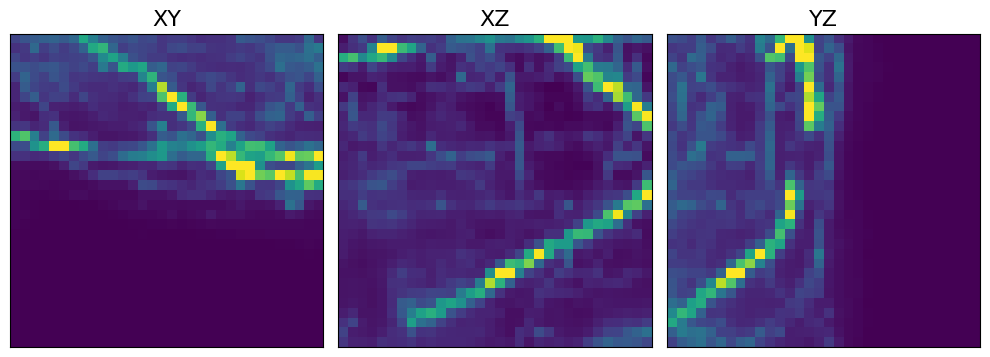

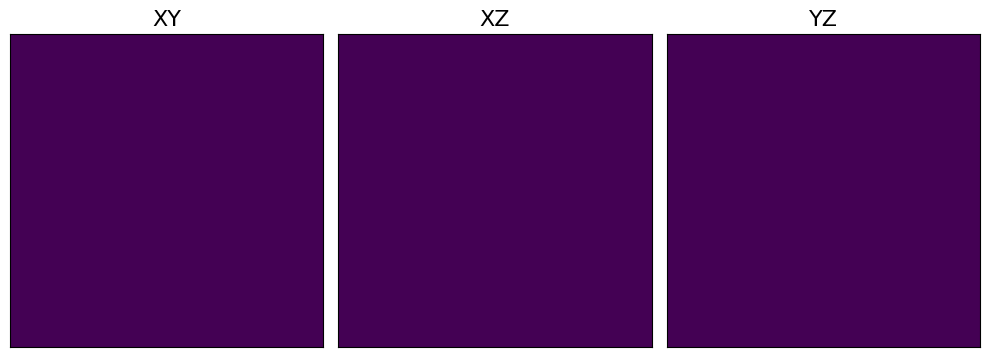

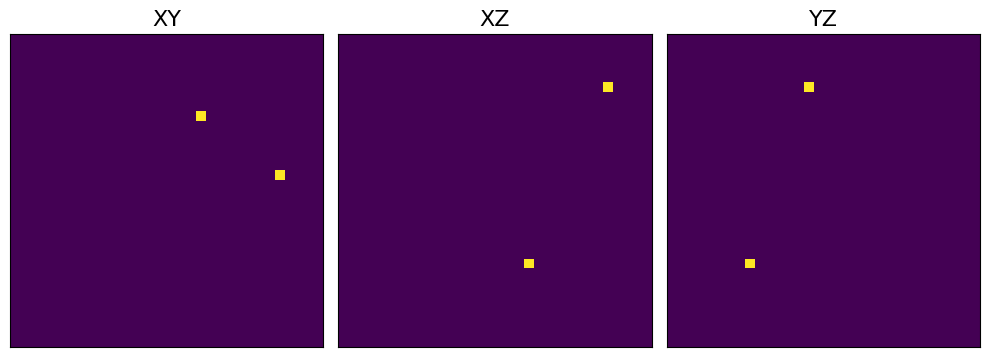

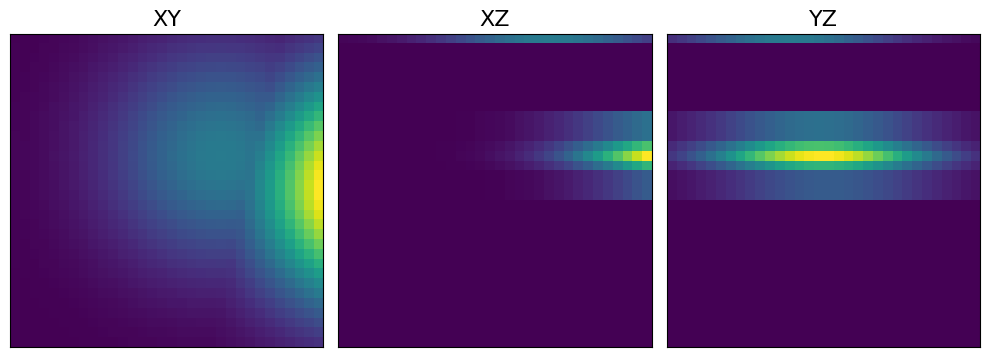

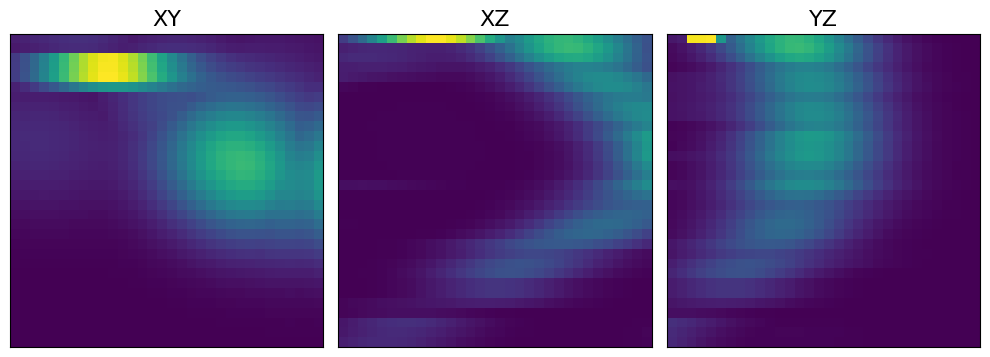

In [4]:
# Region of Interest
xyz = [15702.533,16509.564,10990.495]
shape = [64, 64, 64]

# Read Image Patch
voxel = img_util.to_voxels(xyz, multiscale=multiscale)
img_patch = img_util.get_patch(img, voxel, shape, from_center=True)

# Step 1: Generate Initial Proposals
t0 = time()
img_patch = gaussian_filter(img_patch, sigma=0.5)
proposals_1, LoG_1 = detect_blobs(img_patch, bright_threshold, 8, d)
proposals_2, LoG_2 = detect_blobs(img_patch, bright_threshold, 5, d)
proposals_3, LoG_3 = detect_blobs(img_patch, bright_threshold, 3.5, d)
proposals = proposals_1 + proposals_2 + proposals_3

# Step 2: Filter Initial Proposals
proposals = spg.spatial_filtering(proposals, 5)
proposals = spg.brightness_filtering(img_patch, proposals, 10)
proposals, rejects = gaussian_fitness_filtering(img_patch, proposals)

print("\n# Proposals:", len(proposals))
print("# Rejects:", len(rejects))
print("Runtime:", time() - t0)

# Visualize Results
proposals_img = img_util.get_detections_img(img_patch.shape, proposals)
rejects_img = img_util.get_detections_img(img_patch.shape, rejects)

img_util.plot_mips(img_patch[d:-d, d:-d, d:-d], clip_bool=True)
img_util.plot_mips(proposals_img[d:-d, d:-d, d:-d])
img_util.plot_mips(rejects_img[d:-d, d:-d, d:-d])
img_util.plot_mips(LoG_1[d:-d, d:-d, d:-d])
img_util.plot_mips(LoG_2[d:-d, d:-d, d:-d])


### Visualize Gaussian Fit

Fitness Score: 0.6009024634975639
Parameters: [  5.65519805   2.78948253   1.65181575   0.82336421   0.8690589
   1.1508867  349.60069179  78.65567879]


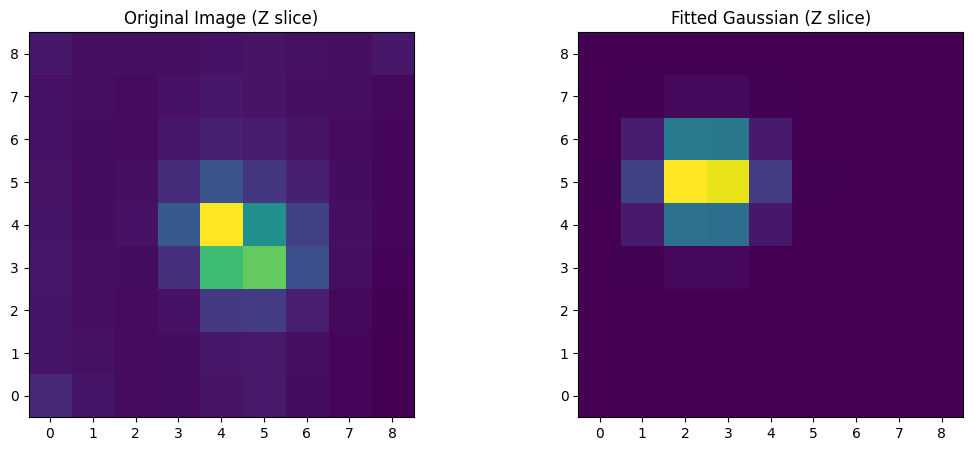

In [5]:
# Parameters
margin = 16
r = 4

# Get valid center
while True:
    voxel = sample(proposals + rejects, 1)[0]
    if spg.is_inbounds(img_patch.shape, voxel, margin=margin):
        break

# Get patch from img
x0, y0, z0 = tuple(map(int, voxel))
x_min, x_max = max(0, x0 - r), min(img_patch.shape[0], x0 + r + 1)
y_min, y_max = max(0, y0 - r), min(img_patch.shape[1], y0 + r + 1)
z_min, z_max = max(0, z0 - r), min(img_patch.shape[2], z0 + r + 1)
nbhd = img_patch[x_min:x_max, y_min:y_max, z_min:z_max]
img_vals = nbhd.ravel()

# Generate coordinates
xyz = [np.linspace(0, nbhd.shape[i], nbhd.shape[i]) for i in range(3)]
x, y, z = np.meshgrid(xyz[0], xyz[1], xyz[2], indexing='ij')
xyz = (x.ravel(), y.ravel(), z.ravel())

# Initialize parameters guess
shape = nbhd.shape
x0, y0, z0 = shape[0] // 2, shape[1] // 2, shape[2] // 2
p0 = (x0, y0, z0, 2, 2, 2, np.max(nbhd), np.min(nbhd))

# Fit Gaussian
try:
    params, _ = curve_fit(spg.gaussian_3d, xyz, img_vals, p0=p0)
except RuntimeError:
    params = np.zeros((9))

# Fitness quality
print("Fitness Score:", spg.fitness_score(nbhd, xyz, params))
print("Parameters:", params)

# Visualize image patch
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
axs[0].imshow(nbhd[:, :, z0], cmap='viridis', origin='lower')
axs[0].set_title("Original Image (Z slice)")

# Visualize fitted gaussian
if params is not None:
    fitted_blob = spg.gaussian_3d((x, y, z), *params).reshape(x.shape)
    axs[1].imshow(fitted_blob[:, :, z0], cmap='viridis', origin='lower')
    axs[1].set_title("Fitted Gaussian (Z slice)")


<div style="background-color: darkblue; padding: 10px; color: white;">

## Section 2: Proposal Generation in Whole Brain

<div style="font-size: 18px;">
    Next, we provide an overview of the main routines used to generate soma proposals on the scale of a whole brain.

</div>

### Imports

In [6]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from random import sample
from tqdm import tqdm

### Main

In [7]:
## Parameters
margin = 16
overlap = (28, 28, 28)
patch_shape = (64, 64, 64)

bright_threshold = 170
save_results = False

# Initializations
offsets = img_util.sliding_window_coords_3d(img, patch_shape, overlap)
output_dir = "/root/capsule/results/soma_proposals"
print("\n# Image Patches:", len(offsets))

# Proposal generation
t0 = time()
with ThreadPoolExecutor() as executor:
    # Assign threads
    threads = list()
    for offset in sample(offsets, 100):
        threads.append(
            executor.submit(
                spg.generate_proposals,
                img,
                offset,
                margin,
                patch_shape,
                multiscale,
                bright_threshold,
            )
        )

    # Process results
    proposals = list()
    pbar = tqdm(total=len(threads))
    for thread in as_completed(threads):
        proposals.extend(thread.result())
        pbar.update(1)
    pbar.update(1)

# Global filtering
proposals = spg.spatial_filtering(proposals, 35)
print("\n# Proposals Generated:", len(proposals))
print("Runtime:", time() - t0)

# Save results (if applicable)
if save_results:
    util.mkdir(output_dir, delete=True)
    util.write_points(output_dir, proposals, color="0.0 0.0 1.0", prefix="proposal_")

  1%|          | 1/100 [00:00<00:11,  8.69it/s]


# Image Patches: 256907


 99%|█████████▉| 99/100 [00:10<00:00,  5.71it/s]


# Proposals Generated: 21
Runtime: 10.833604097366333
